In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Artificial Time Series Prediction

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

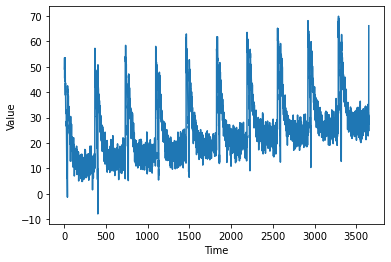

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                         input_shape = [None]),
  tf.keras.layers.LSTM(32, return_sequences = True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 21.2230 - mae: 21.7225
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 19.3641 - mae: 19.8633
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 17.2925 - mae: 17.7913
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 15.0287 - mae: 15.5270
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 12.5794 - mae: 13.0773
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 10.0914 - mae: 10.5885
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 7.8751 - mae: 8.3665
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 6.4360 - mae: 6.9202
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 5.7491 - mae: 6.2303
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 5.3933 - mae: 5.8730
Epoch 11/100
94/94 [===========================

(1e-07, 0.0001, 0.0, 10.0)

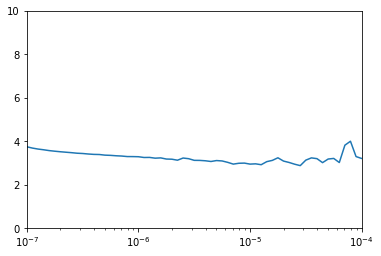

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 10])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                         input_shape = [None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 100)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                                                                          

Epoch 1/500
94/94 [==============================] - 1s 11ms/step - loss: 5.5724 - mae: 6.0460
Epoch 2/500
94/94 [==============================] - 1s 10ms/step - loss: 4.4003 - mae: 4.8678
Epoch 3/500
94/94 [==============================] - 1s 11ms/step - loss: 4.3305 - mae: 4.7992
Epoch 4/500
94/94 [==============================] - 1s 11ms/step - loss: 4.1555 - mae: 4.6219
Epoch 5/500
94/94 [==============================] - 1s 11ms/step - loss: 4.0811 - mae: 4.5475
Epoch 6/500
94/94 [==============================] - 1s 11ms/step - loss: 3.9898 - mae: 4.4567
Epoch 7/500
94/94 [==============================] - 1s 10ms/step - loss: 3.9102 - mae: 4.3771
Epoch 8/500
94/94 [==============================] - 1s 11ms/step - loss: 3.9122 - mae: 4.3790
Epoch 9/500
94/94 [==============================] - 1s 10ms/step - loss: 4.0100 - mae: 4.4797
Epoch 10/500
94/94 [==============================] - 1s 11ms/step - loss: 3.8208 - mae: 4.2863
Epoch 11/500
94/94 [=============================

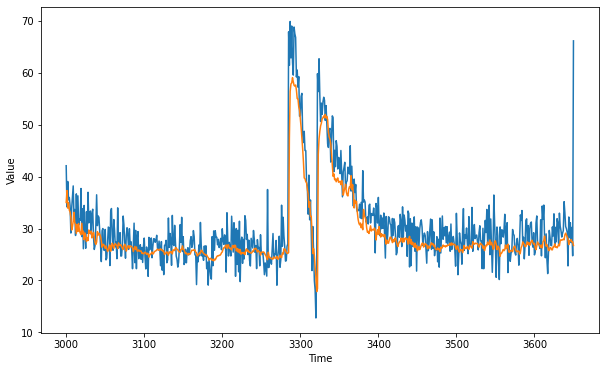

In [ ]:
forecast = []
results = []
for time in range(split_time-window_size, len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0, 0]



plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.1911266

<Figure size 432x288 with 0 Axes>

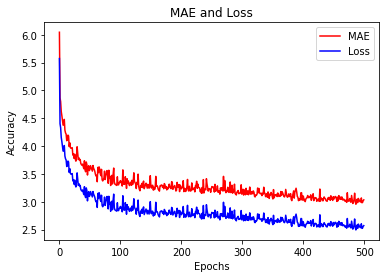

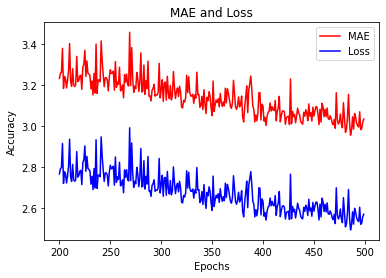

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()